In [15]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [31]:
# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Balance Classes

In [17]:
# First we will balance our classes

# read in dataset
df = pd.read_pickle('data/combined_data_cleaned_corrected.pkl')

0    0.813057
1    0.186943
Name: shootings_abv_avg, dtype: float64


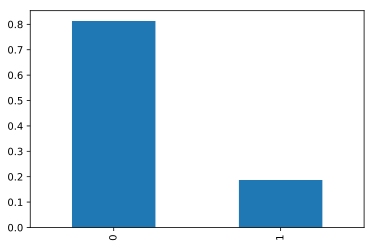

In [18]:
# demonstrate class imbalance
target_pcts = df.shootings_abv_avg.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

In [79]:
## Add some features:

# Minority term:
df['Minority'] = df['Black'] + df['Hispanic'] + df['Native'] + df['Pacific']

# Minority-Drive interaction term
df['Mnr_Drive'] = df['Minority'] * df['Drive']

# Minority-Unemployment interaction term
df['Mnr_Unempl'] = df['Minority'] * df['Unemployment']

# Minority-Voting Age interaction term
df['Mnr_Vtg'] = df['Minority'] * df['VotingAgeCitizen']

# Minority-Poverty interaction term
df['Mnr_Pov'] = df['Minority'] * df['Poverty']

In [19]:
# here is the imbalance in y
Counter(df.shootings_abv_avg)

Counter({0: 2553, 1: 587})

2553 counties have not had police shootings in the past 3 years, and 587 have

In [20]:
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

In [21]:
ros = RandomOverSampler(random_state=0)
ady = ADASYN(random_state=0)
sm = SMOTE(random_state=0)

In [89]:
X_resampled, y_resampled = ros.fit_sample(df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1), 
                                          df.shootings_abv_avg)

In [22]:
X_resampled_ady, y_resampled_ady = ady.fit_sample(df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1), 
                                                  df.shootings_abv_avg)

In [31]:
X_resampled_sm, y_resampled_sm = sm.fit_sample(df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1), 
                                                  df.shootings_abv_avg)

In [23]:
cols = df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1).columns.values
X_resampled_ady = pd.DataFrame(X_resampled_ady, columns = cols)
y_resampled_ady = pd.Series(y_resampled_ady)

In [6]:
X_reg = df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1)
y_reg = df.shootings_abv_avg

# WE KNOW THAT UP TO HERE, EVERYTHING IS IN THE CORRECT ORDER!!!!

In [24]:
# Show we have now balanced the minority class by oversampling
Counter(y_resampled_ady)

Counter({0: 2553, 1: 2401})

In [25]:
type(y_resampled_ady)

pandas.core.series.Series

0    0.515341
1    0.484659
dtype: float64


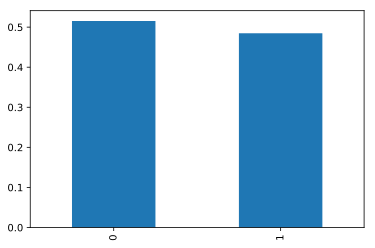

In [26]:
# demonstrate class imbalance
target_pcts = y_resampled_ady.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

# Split data into train, validation, and test sets

In [7]:
## Split the data 80 - 20 train_val/test sets, stratifying on the target variable

X_tr_val, X_te, y_tr_val, y_te = train_test_split(X_resampled_ady, y_resampled_ady, 
                                                  test_size=0.20, random_state=42, 
                                                  stratify = y_reg)

## Split the train_val into train/val sets, stratifying on the target variable 

X_tr, X_val, y_tr, y_val = train_test_split(X_tr_val, y_tr_val, 
                                            test_size=0.25, random_state=42, 
                                            stratify = y_tr_val, )

In [27]:
## Copy for adasyn

X_tr_val_a, X_te_a, y_tr_val_a, y_te_a = train_test_split(X_resampled_ady, y_resampled_ady, 
                                                          test_size=0.20, random_state=42, 
                                                          stratify = y_resampled_ady)

## Split the train_val into train/val sets, stratifying on the target variable 

X_tr_a, X_val_a, y_tr_a, y_val_a = train_test_split(X_tr_val_a, y_tr_val_a, 
                                                    test_size=0.25, random_state=42, 
                                                    stratify = y_tr_val_a)

In [37]:
## Copy for smote

X_tr_val_s, X_te_s, y_tr_val_s, y_te_s = train_test_split(X_resampled_sm, y_resampled_sm, 
                                                          test_size=0.20, random_state=42, 
                                                          stratify = y_resampled_sm)

## Split the train_val into train/val sets, stratifying on the target variable 

X_tr_s, X_val_s, y_tr_s, y_val_s = train_test_split(X_tr_val_s, y_tr_val_s, 
                                                    test_size=0.25, random_state=42, 
                                                    stratify = y_tr_val_s)

# Standardize and Fit

In [28]:
type(y_tr_a)

pandas.core.series.Series

In [29]:
## Fit the scaler to the train set
std = StandardScaler()
std.fit(X_tr)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
pickle.dump(std, open('scaler.pkl', 'wb'))  

In [12]:
## Scale the Predictors on the train, val, and test set
X_tr = std.transform(X_tr)
X_val = std.transform(X_val)
X_te = std.transform(X_te)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [13]:
cols = df.drop(labels = ['shootings_abv_avg', 'County'], axis = 1).columns.values
X_tr = pd.DataFrame(X_tr, columns = cols)
X_val = pd.DataFrame(X_val, columns = cols)
X_te = pd.DataFrame(X_te, columns = cols)

# Save train, val, and test sets for later

In [127]:
# Save them!
type(X_te_a)

pandas.core.frame.DataFrame

In [128]:
X_tr_a.columns.values

array(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'percent_men'],
      dtype=object)

In [14]:
X_tr.to_pickle('data/X_tr_reg.pkl')
X_val.to_pickle('data/X_val_reg.pkl')
X_te.to_pickle('data/X_te_reg.pkl')

y_tr.to_pickle('data/y_tr_reg.pkl')
y_val.to_pickle('data/y_val_reg.pkl')
y_te.to_pickle('data/y_te_reg.pkl')

# EDA to put me at ease

In [47]:
df_resampled = X_tr_s

In [48]:
df_resampled.columns

Index(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'percent_men'],
      dtype='object')

In [50]:
df_resampled['shootings_abv_avg'] = y_resampled_sm

In [51]:
df_resampled.sample(10)

,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,IncomePerCap,Poverty,ChildPoverty,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,percent_men,shootings_abv_avg
454,-0.163808,0.518883,-0.675596,0.283060,-0.367802,0.785815,-2.130269,-0.444431,-0.569509,-0.742072,...,0.795319,-0.552727,-0.674019,-0.008672,0.414951,-0.745723,0.308241,-0.120140,0.446342,0
1151,-0.493852,0.936063,-0.587981,-0.253340,-0.291265,-0.202114,1.047090,0.285505,-0.802596,-1.053132,...,0.222743,0.268473,0.364421,0.064879,-0.336078,0.473147,-0.406486,-0.261528,-0.188597,0
978,1.156365,-1.494014,0.312061,-0.253340,3.994861,-0.202114,-0.569473,7.432131,0.196347,0.083846,...,0.795319,1.690550,1.793655,1.153445,-1.436422,0.168430,-0.168244,-0.120140,-1.233027,0
376,-0.603866,1.014285,-0.611876,-0.225832,-0.406071,-0.202114,0.717584,-0.118840,-0.269826,-0.366655,...,0.146399,0.148297,0.107902,-0.920714,0.886527,0.351260,0.069998,0.056594,0.013847,0
2288,-0.501186,0.774406,-0.500367,-0.239586,0.512384,-0.202114,-0.402997,0.881455,-1.118928,-0.978049,...,-0.311662,0.548883,0.966035,1.079893,-0.912449,-0.593365,-0.644728,-0.685691,-0.400244,0
1538,1.036511,-2.354932,0.888692,2.976567,-0.375424,-0.202114,-0.102444,-1.405500,1.974375,2.119890,...,0.153043,0.008093,-1.448961,-1.190744,1.476154,-0.099811,-0.072847,2.834328,0.786430,0
696,2.058489,-0.888701,-0.555254,-0.163263,-0.489748,-0.202114,-1.354472,-0.416662,0.435127,0.438698,...,-0.655603,-0.019516,-0.690871,0.691936,-0.533811,-0.497214,0.046542,-0.439363,0.351319,1
2826,-0.457180,0.737903,-0.564086,-0.239586,0.397577,-0.202114,-0.787846,3.116438,-2.017977,-2.039943,...,0.680803,0.588941,2.058652,1.403521,-1.296696,-0.623836,-0.406486,-1.463323,-0.133385,0
1115,-0.173800,0.315859,-0.339912,-0.051750,0.008602,1.204610,0.224552,-0.013751,-0.340605,-0.376241,...,0.258517,-0.060316,0.115997,1.066107,-1.098581,-0.309109,0.045829,-0.234206,-0.300155,0
1823,-0.237151,0.362440,-0.149908,-0.253340,0.091425,-0.202114,-0.532242,-0.056620,-0.602807,-0.892239,...,-0.120803,1.490258,0.018205,0.417928,-0.440872,-0.136288,0.546483,-0.014100,-0.266815,0


## Make pairplots with hues of important features

In [52]:
df_resampled.columns

Index(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'percent_men', 'shootings_abv_avg'],
      dtype='object')

In [53]:
subset_df = df_resampled[['Office', 'SelfEmployed', 'percent_men', 
                          'Asian', 'Hispanic', 'White', 'MeanCommute',
                         'PrivateWork', 'Walk', 'Poverty', 'shootings_abv_avg']].copy()

AttributeError: 'AxesSubplot' object has no attribute 'show'

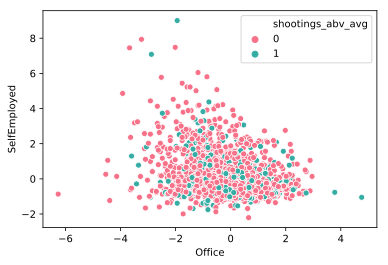

In [54]:
subsub = subset_df[['Office', 'SelfEmployed', 'shootings_abv_avg']]
cols = list(subsub.columns)
for i, col1 in enumerate(cols):
    if i < len(cols)-1:
        for j, col2 in enumerate(cols):
            if j > i:
                g = sns.scatterplot(col1, col2, hue='shootings_abv_avg', data = subsub, palette='husl')
                g.show()

In [ ]:
sns.scatterplot('Office', 'SelfEmployed', hue = 'shootings_abv_avg', data=subset_df, palette='husl')

In [ ]:
sns.scatterplot('Office', 'shootings_abv_avg', data=subset_df, palette='husl')

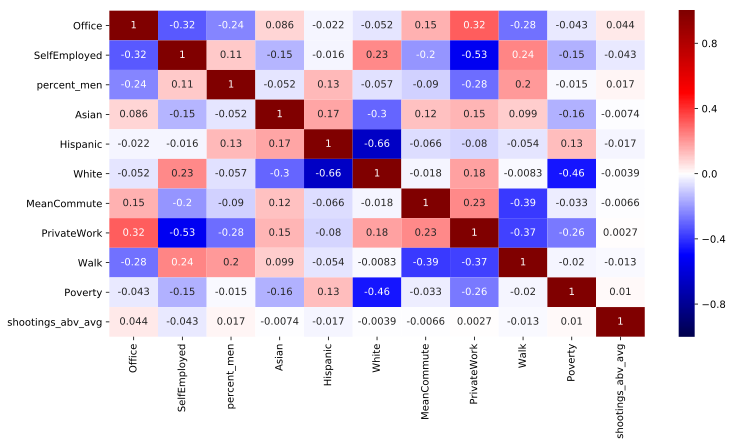

In [55]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(subset_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [110]:
df.corr()

,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,IncomePerCap,Poverty,ChildPoverty,...,SelfEmployed,FamilyWork,Unemployment,shootings_abv_avg,percent_men,Minority,Mnr_Drive,Mnr_Unempl,Mnr_Vtg,Mnr_Pov
Hispanic,1.000000,-0.600157,-0.113693,-0.041844,0.139399,0.040539,-0.655896,-0.059352,0.077246,0.074423,...,-0.003045,-0.027996,0.049164,0.106590,0.141085,0.606092,0.588949,0.350557,0.524740,0.417904
White,-0.600157,1.000000,-0.597302,-0.293902,-0.274318,-0.126079,0.538100,0.207859,-0.457808,-0.448809,...,0.232646,0.093439,-0.453463,-0.107472,-0.043421,-0.983530,-0.952911,-0.828049,-0.968606,-0.868824
Black,-0.113693,-0.597302,1.000000,-0.101551,0.015491,-0.048506,0.014951,-0.259514,0.466852,0.496795,...,-0.304497,-0.122478,0.430879,0.002872,-0.105193,0.622329,0.664110,0.587714,0.691886,0.624559
Native,-0.041844,-0.293902,-0.101551,1.000000,-0.010524,0.046536,-0.153530,-0.128271,0.251710,0.190077,...,0.038635,0.071560,0.297878,0.019198,0.068242,0.282580,0.176235,0.435278,0.264561,0.372256
Asian,0.139399,-0.274318,0.015491,-0.010524,1.000000,0.451426,-0.286821,0.415154,-0.149559,-0.176435,...,-0.160041,-0.091894,-0.039969,0.099281,-0.032151,0.115007,0.070176,0.029132,0.091980,-0.002998
Pacific,0.040539,-0.126079,-0.048506,0.046536,0.451426,1.000000,-0.083852,0.045811,-0.039217,-0.052892,...,-0.004092,-0.007462,-0.010492,0.036461,0.049866,0.030881,0.017214,0.006716,0.026853,-0.003253
VotingAgeCitizen,-0.655896,0.538100,0.014951,-0.153530,-0.286821,-0.083852,1.000000,-0.006567,-0.048865,-0.033603,...,0.122459,0.059994,-0.031253,-0.110355,0.034286,-0.512950,-0.474221,-0.341731,-0.400526,-0.375325
IncomePerCap,-0.059352,0.207859,-0.259514,-0.128271,0.415154,0.045811,-0.006567,1.000000,-0.722457,-0.684335,...,0.092208,-0.020987,-0.465582,0.000560,-0.116589,-0.283331,-0.307461,-0.351545,-0.290645,-0.430151
Poverty,0.077246,-0.457808,0.466852,0.251710,-0.149559,-0.039217,-0.048865,-0.722457,1.000000,0.924046,...,-0.168894,-0.013668,0.649366,0.043765,-0.056827,0.497836,0.496761,0.588916,0.510947,0.703610
ChildPoverty,0.074423,-0.448809,0.496795,0.190077,-0.176435,-0.052892,-0.033603,-0.684335,0.924046,1.000000,...,-0.175410,-0.035160,0.616688,0.027636,-0.058772,0.493981,0.501569,0.556199,0.513074,0.668446


In [34]:
df.columns

Index(['County', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'shootings_abv_avg', 'percent_men'],
      dtype='object')

In [51]:
a = dict(df.iloc[1,:].drop(labels = ['shootings_abv_avg', 'County']))
a

{'Hispanic': 4.4,
 'White': 83.1,
 'Black': 9.5,
 'Native': 0.8,
 'Asian': 0.7,
 'Pacific': 0.0,
 'VotingAgeCitizen': 0.7640440597954367,
 'IncomePerCap': 29364,
 'Poverty': 11.8,
 'ChildPoverty': 16.1,
 'Professional': 35.7,
 'Service': 18.2,
 'Office': 25.6,
 'Construction': 9.7,
 'Production': 10.8,
 'Drive': 84.7,
 'Carpool': 7.6,
 'Transit': 0.1,
 'Walk': 0.8,
 'OtherTransp': 1.1,
 'WorkAtHome': 5.6,
 'MeanCommute': 27.0,
 'Employed': 0.44023898505114084,
 'PrivateWork': 80.7,
 'PublicWork': 12.9,
 'SelfEmployed': 6.3,
 'FamilyWork': 0.1,
 'Unemployment': 5.5,
 'percent_men': 48.94}

In [54]:
b = pd.DataFrame(a, index=[0])

In [56]:
b_transformed = std.transform(b)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [64]:
df.sample(40).MeanCommute

2497    29.8
1404    28.3
2010    19.8
2284    20.2
868     20.3
254     30.3
1281    20.8
690     23.9
896     20.9
2763    23.0
1990    17.3
1383    26.0
290     26.8
3       30.0
1713    14.2
1791    32.0
2469    34.4
1133    21.8
585     16.0
2846    29.2
645     19.0
843     14.7
2963    21.5
891     15.8
653     27.6
2507    28.6
882     16.5
253     12.6
1494    18.0
2993    31.2
297     17.4
261     19.2
2872    33.7
45      25.5
435     25.2
1377    17.9
936     14.5
2168    20.9
1985    21.9
1170    21.6
Name: MeanCommute, dtype: float64